In [81]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [78]:
resultdir = "/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative"
resultre = re.compile(r'^.+\/(?P<modelname>[^_]+)_(?P<imgsz>[\d]+)imgsz_(?P<camera>.+?)-(?P<epochs>[\d]+)epochs-val$')
metricre = re.compile(r'^(?P<category>category)?_*(?P<metric>metrics/)?(?P<name>[^(]*).*?$')

model_parent = "yolo"
val_results = []

for valresult in glob.glob(f"{resultdir}/*-val"):
    match = resultre.match(valresult)
    if match is None:
        print(F"didn't match directory name {valresult}")
        continue
    params = match.groupdict()
    new_result = params.copy()
    new_result['modelname'] = f"{model_parent}{new_result['modelname']}"

    if not os.path.exists(f"{valresult}/metrics.json"):
        print(f"{valresult}/metrics.json doesn't exist right now, skipping")
        continue
    with open(f"{valresult}/metrics.json") as r:
        metrics = json.load(r)
        for k, v in metrics.items():
            kmatch = metricre.match(k)
            if kmatch is not None:
                md = kmatch.groupdict()
                if md['metric'] is not None:
                    k = md['name']
                    new_result[ md['name'] ] = v
                elif md['category'] is not None:
                    if len(v) == 0:
                        new_result[ f"{md['category']}_{md['name']}" ] = 0
                    else:
                        new_result[ f"{md['category']}_{md['name']}" ] = v[0]
                else:
                    new_result[ k ] = v
        val_results.append(new_result.copy())

In [137]:
val_df = pd.DataFrame(val_results)
val_df = val_df.astype({'imgsz': 'int', 'epochs':'int',
                        'precision': 'float', 'recall': 'float', 
                        'mAP50': 'float', 'mAP50-95': 'float',
                       })
val_df.rename(columns={'imgsz': "Image Size (px)", 'epochs': 'Epochs',
                       'precision': 'Precision', 'recall': 'Recall',
                       'camera': 'Camera', 'modelname': 'Model Name',
                      }, inplace=True)
display(val_df)
val_df.dtypes

,Model Name,Image Size (px),Camera,Epochs,Precision,Recall,mAP50,mAP50-95,fitness,category_mAP50-95
0,yolo11s,2880,IP8M-H-SW,18,0.871442,0.624390,0.754066,0.406300,0.441076,0.406300
1,yolo11m,720,IP8M-H-SW,45,0.827079,0.234146,0.288205,0.096145,0.115351,0.096145
2,yolo11s,720,IP8M-H-SW,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,yolo11m,720,IP8M-H-SW,80,0.898881,0.312195,0.365109,0.135446,0.158412,0.135446
4,yolo11m,2880,IP8M-H-SW,10,0.933523,0.760976,0.838409,0.467155,0.504280,0.467155
...,...,...,...,...,...,...,...,...,...,...
199,yolo11m,720,IP8M-H-SW,21,0.870433,0.185366,0.224851,0.068776,0.084384,0.068776
200,yolo11s,2880,IP8M-H-SW,22,0.907304,0.716194,0.820273,0.454390,0.490979,0.454390
201,yolo11m,1440,IP8M-H-SW,1,0.544512,0.326563,0.284245,0.080540,0.100911,0.080540
202,yolo11m,1440,IP8M-H-SW,14,0.814278,0.580488,0.621456,0.252074,0.289013,0.252074


Model Name            object
Image Size (px)        int64
Camera                object
Epochs                 int64
Precision            float64
Recall               float64
mAP50                float64
mAP50-95             float64
fitness              float64
category_mAP50-95    float64
dtype: object

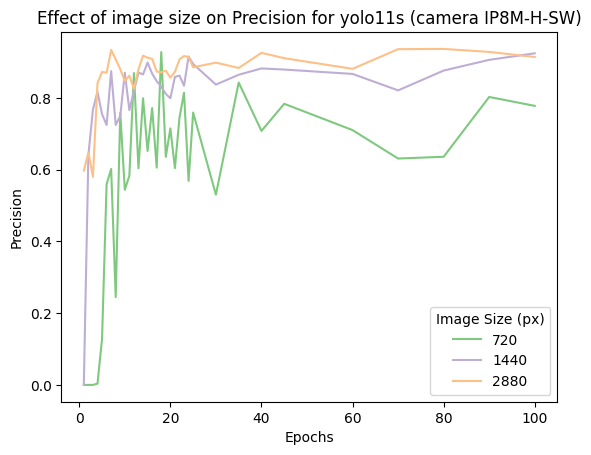

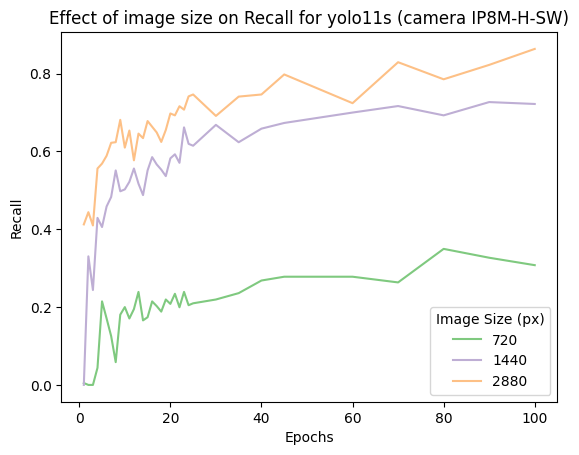

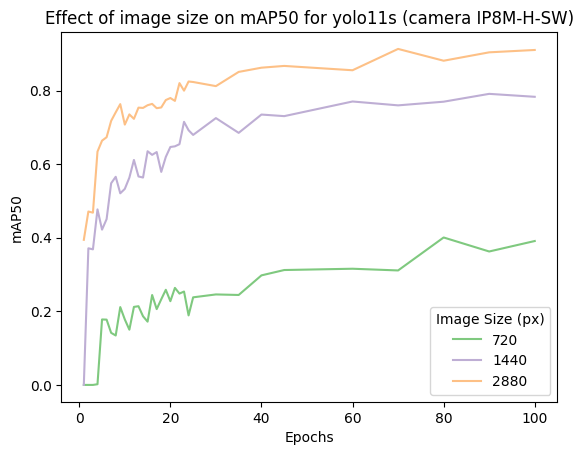

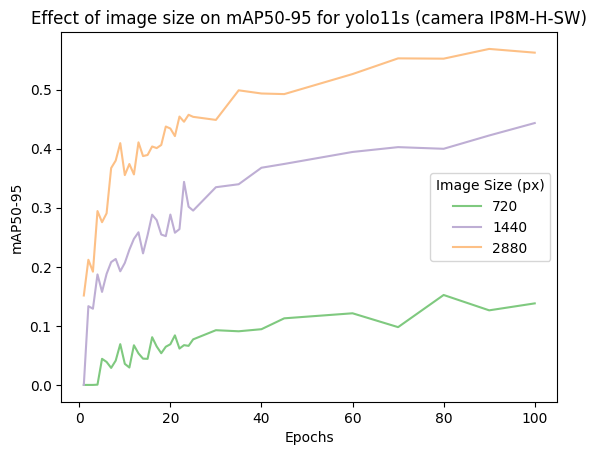

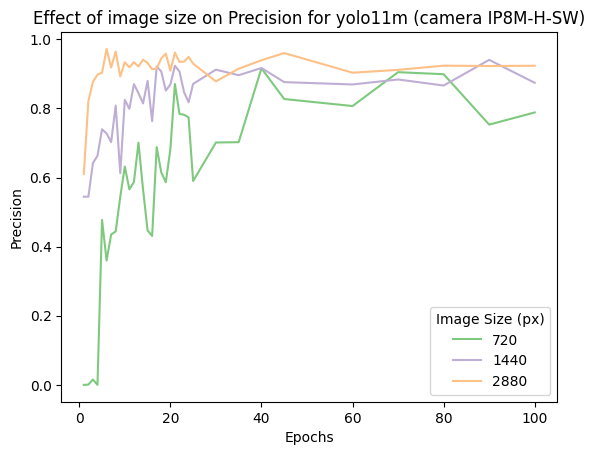

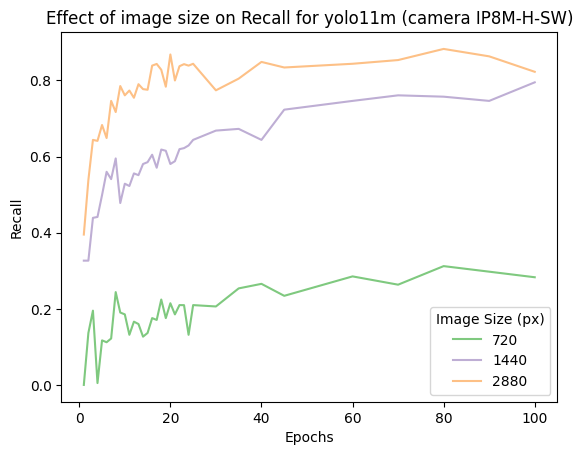

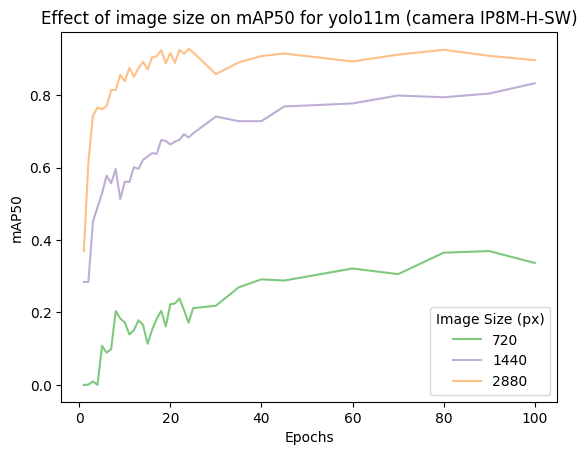

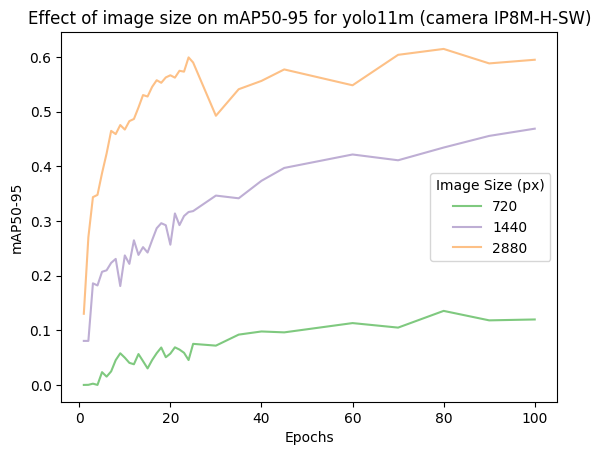

In [142]:
plot_metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95', ]

def join_mask( mask_list ):
    full_mask = None
    for m in mask_list:
        if full_mask is None:
            full_mask = m
        else:
            full_mask = full_mask & m
    return full_mask

# iterate over cameras
mask_list = []
for camera in val_df['Camera'].unique().tolist():
    mask_list.append(val_df['Camera'] == camera) 
    
    # iterate over model
    for model in val_df[cam_mask]['Model Name'].unique().tolist(): 
        mask_list.append((val_df['Model Name'] == model))

        current_df = val_df[ join_mask( mask_list ) ]
        #display(current_df)
        for metric in plot_metrics:
            fig = plt.figure()
            axs = sns.lineplot(data=current_df, x='Epochs', y=metric, hue='Image Size (px)', palette='Accent' )
            axs.set_title(f"Effect of image size on {metric} for {model} (camera {camera})") 
        mask_list.pop()
    mask_list.pop()